In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import gmaps
import gmaps.datasets
import requests
import json
from ApiKey import key1
from ApiKey import gkey
from ApiKey import key2
gmaps.configure(api_key = gkey)

In [2]:
# import csvs
readCrime = pd.read_csv('crimedata2.csv')
readCounty = pd.read_csv('NumberUnemployed.csv')
# print(readCounty)
secondCrime = pd.read_csv('CrimeData.csv')
unemployment = pd.read_csv('PercentUnemployed.csv')
laborForce = pd.read_csv('TotalEmployment.csv')
statecodes = pd.read_csv('StateCodes.csv')

In [3]:
# Convert county names to lower case
readCrime['county'] = readCrime['county'].str.lower()
secondCrime['county'] = secondCrime['county'].str.lower()
readCounty['county'] = readCounty['county'].str.lower()
laborForce['county'] = laborForce['county'].str.lower()
unemployment['county'] = unemployment['county'].str.lower()

readCounty['county'] = readCounty['county'].str.replace(' county','')
laborForce['county'] = laborForce['county'].str.replace(' county','')
unemployment['county'] = unemployment['county'].str.replace(' county','')

# Add two crime dataframes together and reset index
combCrime = readCrime.append(secondCrime)
combCrime.reset_index(inplace=True)
combCrime.to_csv('combCrime.csv')
# Merge county dataframes with county dataframe, percents with that, and population with that
mergedDF = readCounty.merge(combCrime, on=['state','county','Year'], how='inner')
mergedDF.to_csv('merge.csv')
percentDF = mergedDF.merge(unemployment, on=['state','county','Year'])
percentDF.to_csv('percentDF.csv')
# Grab only columns we want
finalDF = percentDF.merge(laborForce, on=['state','county','Year'])
finalDF.to_csv('finalDF.csv')
# Make Pretty
selectColumnsDF = finalDF[['Year', 'state', 'county', 'Average (Monthly) Number Unemployed', 
                         'Average (Monthly) Percent Unemployed', 'count', 'Average Total Employment']]
formattedDF = selectColumnsDF.rename(columns={'state': 'State', 'county': 'County', 
                            'Average (Monthly) Number Unemployed': 'Average Number Unemployed',
                           'Average (Monthly) Percent Unemployed': 'Average Percent Unemployed',
                           'count': 'Number of Crimes', 'Average Total Employment': 'Total Labor Force'})

# Show
formattedDF = formattedDF[formattedDF['Number of Crimes'] > 0]

In [4]:
formattedDF['Crimes Per 100 Workers'] = (formattedDF['Number of Crimes'] / formattedDF['Total Labor Force'])*100
# formattedDF.describe()

In [5]:
formattedDF['County_state'] = formattedDF['County'].astype(str) + ' county, '+ formattedDF['State'].astype(str)


In [6]:

# for county in formattedDF['County_state'].unique:
#     target_city = county
#     target_url = ('https://maps.googleapis.com/maps/api/geocode/json?'
#     'address={0}&key={1}').format(target_city, gkey)
#     jdata = requests.get(target_url).json()
# #     print(jdata)
# #     break
#     formattedDF[(formattedDF['County_state'] == county)]['lat'] = jdata['results'][0]['geometry']['location']['lat']
#     formattedDF[(formattedDF['County_state'] == county)]['lng'] = jdata['results'][0]['geometry']['location']['lng']

In [7]:
# formattedDF

In [8]:
# fig = gmaps.figure()
# # heatmap_layer = gmaps.heatmap_layer(
#     df[['latitude', 'longitude']], weights=df['magnitude'],
#     max_intensity=30, point_radius=3.0

In [9]:
year2010DF = formattedDF[formattedDF['Year']==2010]
# year2010DF.to_csv('2010early.csv')
year2011DF = formattedDF[formattedDF['Year']==2011]
year2012DF = formattedDF[formattedDF['Year']==2012]
year2013DF = formattedDF[formattedDF['Year']==2013]
year2014DF = formattedDF[formattedDF['Year']==2014]
year2015DF = formattedDF[formattedDF['Year']==2015]
# year2010DF.describe()
# year2010DF[formattedDF['Total Labor Force'] >= 500000].describe()

In [10]:
def getyty (DF1, DF2, year):
    x = DF1['Average Percent Unemployed']
    meanval = x.mean()
    stdevval = x.std()
    
    bins = [0, meanval - stdevval/2, meanval + stdevval/2,  np.inf ]
    labels = ['Low', 'Medium', 'High']
    DF1["U_Range"] = pd.cut(DF1["Average Percent Unemployed"], bins, labels=labels)
    x = DF1['Crimes Per 100 Workers']
    meanval = x.mean()
    stdevval = x.std()
    bins = [0, meanval - stdevval/2, meanval + stdevval/2,  np.inf ]
    DF1["C_Range"] = pd.cut(DF1["Crimes Per 100 Workers"], bins, labels=labels)
   
    yty = DF1.merge(DF2, on=('State', 'County'), how='inner')
#     print(yty)
    yty['WF_Change'] = 100 * (yty['Total Labor Force_y']-yty['Total Labor Force_x'])/yty['Total Labor Force_x']
    yty['U_Change'] = 100 * (yty['Average Percent Unemployed_y']-yty['Average Percent Unemployed_x'])/yty['Average Percent Unemployed_x']
    yty['C_Change'] = 100 * (yty['Crimes Per 100 Workers_y']-yty['Crimes Per 100 Workers_x'])/yty['Crimes Per 100 Workers_x']
    ygb = yty.groupby(['U_Range','C_Range'])
    z = (ygb.agg({'WF_Change':'mean', 'U_Change':'mean', 'C_Change':'mean'}))
    z.reset_index(inplace=True)
    z['year'] = year
    z['label'] = (z['U_Range'].astype(str) + '_Unemployment:'+  z['C_Range'].astype(str) + '_Crime')
    return z
def getcolor (Mylabel):
    if Mylabel == 'High_Unemployment:High_Crime':
        color = '#8B0000'
    elif  Mylabel == 'High_Unemployment:Medium_Crime':
        color = '#EE0000'
    elif  Mylabel == 'High_Unemployment:Low_Crime':
         color = '#FF8000'
    elif  Mylabel == 'Medium_Unemployment:High_Crime':
        color = '#104E8B'
    elif  Mylabel == 'Medium_Unemployment:Medium_Crime':
        color = '#1E90FF'
    elif  Mylabel == 'Medium_Unemployment:Low_Crime':
        color = '#87CEFA'
    elif  Mylabel == 'Low_Unemployment:High_Crime':
        color = '#008B00'
    elif  Mylabel == 'Low_Unemployment:Medium_Crime':
        color = '#00CD00'
    elif  Mylabel == 'Low_Unemployment:Low_Crime':
         color = '#00FF00'
    else:
        color = '#FFFFFF'
    return color
    

LargeCounty = getyty(year2010DF[formattedDF['Total Labor Force'] >= 500000], year2011DF.copy(), 2010)
LargeCounty = LargeCounty.append(getyty(year2011DF[formattedDF['Total Labor Force'] >= 500000], year2012DF.copy(), 2011))
LargeCounty = LargeCounty.append(getyty(year2012DF[formattedDF['Total Labor Force'] >= 500000], year2013DF.copy(), 2012))
LargeCounty = LargeCounty.append(getyty(year2013DF[formattedDF['Total Labor Force'] >= 500000], year2014DF.copy(), 2013))
LargeCounty = LargeCounty.append(getyty(year2014DF[formattedDF['Total Labor Force'] >= 500000], year2015DF.copy(), 2014))
LargeCounty['Color'] = LargeCounty['label'].map(getcolor)

MediumCounty = getyty(year2010DF[(formattedDF['Total Labor Force'] >= 100000) & (formattedDF['Total Labor Force'] < 500000)], year2011DF.copy(), 2010)
MediumCounty = MediumCounty.append(getyty(year2011DF[(formattedDF['Total Labor Force'] >= 100000) & (formattedDF['Total Labor Force'] < 500000) ], year2012DF.copy(), 2011))
MediumCounty = MediumCounty.append(getyty(year2012DF[(formattedDF['Total Labor Force'] >= 100000) & (formattedDF['Total Labor Force'] < 500000)], year2013DF.copy(), 2012))
MediumCounty = MediumCounty.append(getyty(year2013DF[(formattedDF['Total Labor Force'] >= 100000) & (formattedDF['Total Labor Force'] < 500000)], year2014DF.copy(), 2013))
MediumCounty = MediumCounty.append(getyty(year2014DF[(formattedDF['Total Labor Force'] >= 100000) & (formattedDF['Total Labor Force'] < 500000)], year2015DF.copy(), 2014))
MediumCounty['Color'] = MediumCounty['label'].map(getcolor)

SmallCounty = getyty(year2010DF[formattedDF['Total Labor Force'] < 100000], year2011DF.copy(), 2010)
SmallCounty = SmallCounty.append(getyty(year2011DF[formattedDF['Total Labor Force'] < 100000], year2012DF.copy(), 2011))
SmallCounty = SmallCounty.append(getyty(year2012DF[formattedDF['Total Labor Force'] < 100000], year2013DF.copy(), 2012))
SmallCounty = SmallCounty.append(getyty(year2013DF[formattedDF['Total Labor Force'] < 100000], year2014DF.copy(), 2013))
SmallCounty = SmallCounty.append(getyty(year2014DF[formattedDF['Total Labor Force'] < 100000], year2015DF.copy(), 2014))
SmallCounty['Color'] = SmallCounty['label'].map(getcolor)


# ret


C:\Users\nsneed\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\nsneed\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nsneed\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\nsneed\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Boole

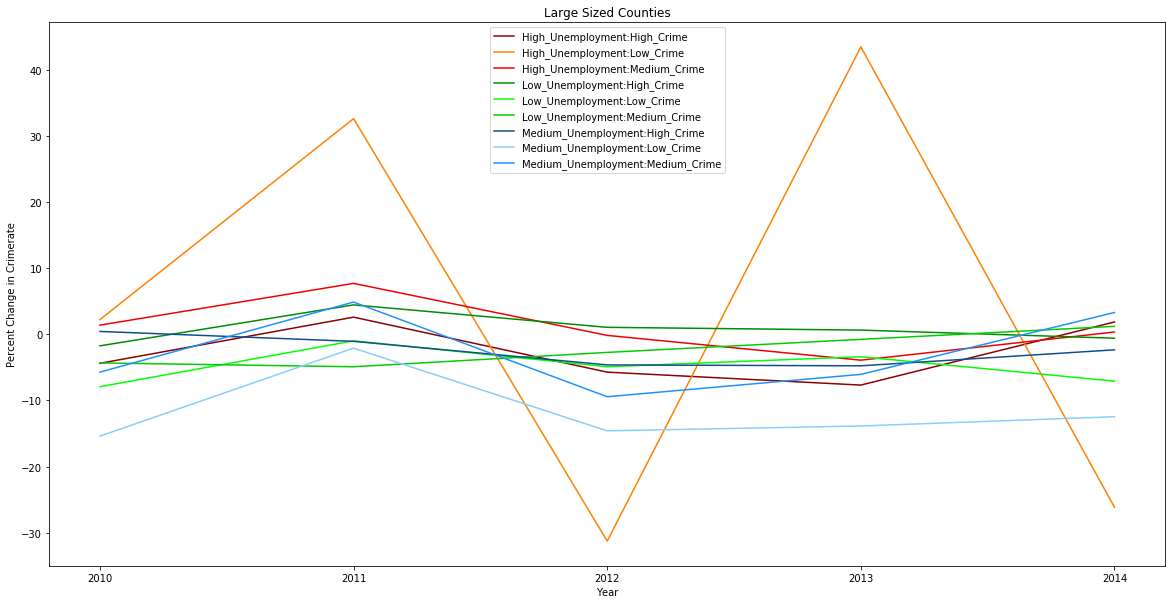

In [11]:
fig, ax = plt.subplots()

for key, grp in LargeCounty.groupby(['label','Color']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='C_Change', c=key[1], label=key[0])
    plt.title("Large Sized Counties")
    plt.ylabel('Percent Change in Crimerate')
    plt.xlabel('Year')
fig.set_size_inches(20, 10)
plt.legend(loc='best')
plt.xticks([2010,2011,2012,2013,2014])
plt.show()

fig.savefig('LargeCountyCrimeRate.png')

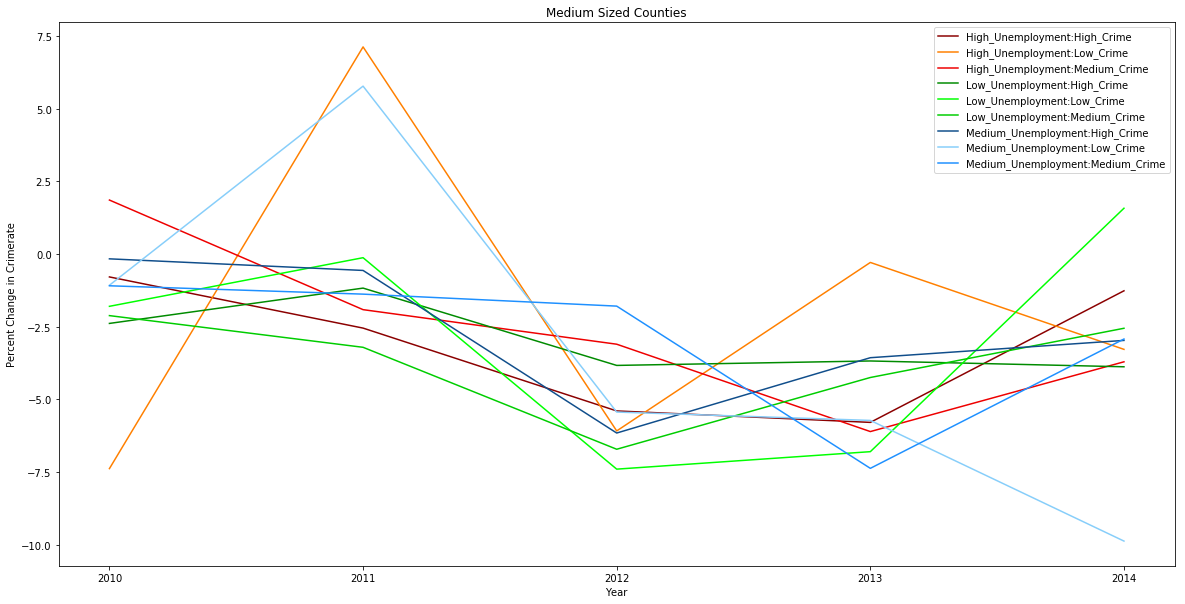

In [12]:
fig, ax = plt.subplots()

for key, grp in MediumCounty.groupby(['label','Color']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='C_Change', c=key[1], label=key[0])
    plt.title("Medium Sized Counties")
fig.set_size_inches(20, 10)
plt.legend(loc='best')
plt.xticks([2010,2011,2012,2013,2014])
plt.ylabel('Percent Change in Crimerate')
plt.xlabel('Year')
plt.show()

fig.savefig('MediumCountyCrimeRate.png')

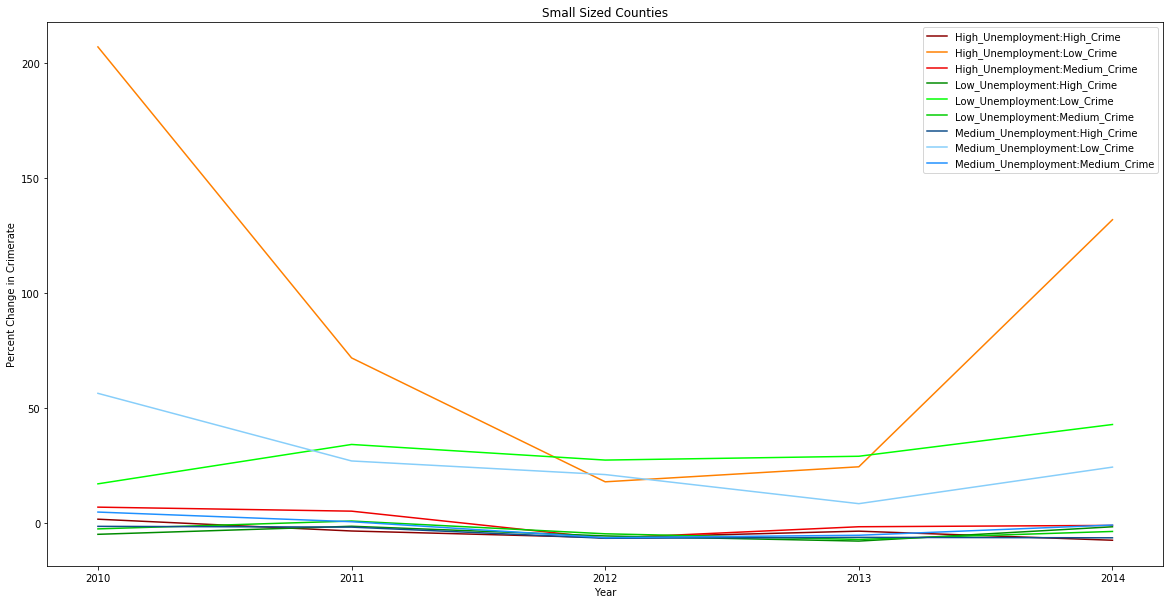

In [13]:
fig, ax = plt.subplots()

for key, grp in SmallCounty.groupby(['label','Color']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='C_Change',  c=key[1], label=key[0])
    plt.title("Small Sized Counties")
fig.set_size_inches(20, 10)
plt.legend(loc='best')
plt.xticks([2010,2011,2012,2013,2014])
plt.ylabel('Percent Change in Crimerate')
plt.xlabel('Year')
plt.show()

fig.savefig('SmallCountyCrimeRate.png')

In [14]:
# # plt.scatter(year2010DF['Average Percent Unemployed'], year2010DF['Crimes Per 100 Workers'])
# x = year2010DF[(formattedDF['Total Labor Force'] > 100000) & (formattedDF['Total Labor Force'] < 250000) ]['Average Percent Unemployed']
# y = year2010DF[(formattedDF['Total Labor Force'] > 100000) & (formattedDF['Total Labor Force'] < 250000) ]['Crimes Per 100 Workers']
# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# line = slope*x+intercept
# # print(line)
# plt.plot(x,y,'o', x, line)
# # plt.plot(x,y,'o')
# # plt.hist(x)
# # plt.hist(y)
# # plt.plot(x, line,'g')
# print(f"Slope = {slope}")
# print(f"R Value = {r_value}")
# print(f"P Value = {p_value}")









In [15]:
# # plt.scatter(year2010DF['Average Percent Unemployed'], year2010DF['Crimes Per 100 Workers'])
# x = year2010DF[(formattedDF['Total Labor Force'] >= 500000) & (formattedDF['Total Labor Force'] > 500000) ]['Average Percent Unemployed']
# y = year2010DF[(formattedDF['Total Labor Force'] >= 500000) & (formattedDF['Total Labor Force'] > 500000) ]['Crimes Per 100 Workers']
# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# line = slope*x+intercept
# # print(line)
# plt.plot(x,y,'o', x, line)
# # plt.plot(x,y,'o')
# # plt.hist(x)
# # plt.hist(y)
# # plt.plot(x, line,'g')
# print(f"Slope = {slope}")
# print(f"R Value = {r_value}")
# print(f"P Value = {p_value}")

In [16]:
# # plt.scatter(year2011DF['Average Percent Unemployed'], year2011DF['Crimes Per 100 Workers'])
# x2 = year2011DF['Average Percent Unemployed']
# y2 = year2011DF['Crimes Per 100 Workers']
# slope, intercept, r_value, p_value, std_err = stats.linregress(x2,y2)
# z2 = [range(len(x2))]
# line2 = slope*x2+intercept

# plt.plot(x2,y2,'o', x2, line2,'g')
# print(f"Slope = {slope}")
# print(f"R Value = {r_value}")
# print(f"P Value = {p_value}")




In [17]:
# # plt.scatter(year2012DF['Average Percent Unemployed'], year2012DF['Crimes Per 100 Workers'])
# x3 = year2012DF['Average Percent Unemployed']
# y3 = year2012DF['Crimes Per 100 Workers']
# slope, intercept, r_value, p_value, std_err = stats.linregress(x3,y3)
# line3 = slope*x3+intercept

# plt.plot(x30,y30,'o', x3, line3)
# # print(f"Slope = {slope}")
# # print(f"R Value = {r_value}")
# # print(f"P Value = {p_value}")

In [18]:
# # plt.scatter(year2013DF['Average Percent Unemployed'], year2013DF['Crimes Per 100 Workers'])
# x3 = year2013DF['Average Percent Unemployed']
# y3 = year2013DF['Crimes Per 100 Workers']
# slope, intercept, r_value, p_value, std_err = stats.linregress(x3,y3)
# line3 = slope*x3+intercept

# plt.plot(x3,y3,'o', x3, line3)
# print(f"Slope = {slope}")
# print(f"R Value = {r_value}")
# print(f"P Value = {p_value}")

In [19]:
# plt.scatter(year2014DF['Average Percent Unemployed'], year2014DF['Crimes Per 100 Workers'])
# x4 = year2014DF['Average Percent Unemployed']
# y4 = year2014DF['Crimes Per 100 Workers']
# slope, intercept, r_value, p_value, std_err = stats.linregress(x4,y4)
# line4 = slope*x4+intercept

# plt.plot(x4,y4,'o', x4, line4)
# plt.ylim(0,100)
# print(f"Slope = {slope}")
# print(f"R Value = {r_value}")
# print(f"P Value = {p_value}")

In [20]:
# # plt.scatter(year2015DF['Average Percent Unemployed'], year2015DF['Crimes Per 100 Workers'])
# x5 = year2015DF['Average Percent Unemployed']
# y5 = year2015DF['Crimes Per 100 Workers']
# slope, intercept, r_value, p_value, std_err = stats.linregress(x5,y5)
# line5 = slope*x5+intercept

# plt.plot(x5,y5,'o', x5, line5)
# print(f"Slope = {slope}")
# print(f"R Value = {r_value}")
# print(f"P Value = {p_value}")